In [1]:
from keras.layers import Input, Dense, Lambda, Flatten, Activation, Merge, Concatenate, Add
from keras import layers
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
from scipy.stats import sem

from keras import backend as K
from keras.models import load_model
import tensorflow as tf

from models import vgg
from models.cvae import CVAE
from utils.angles import deg2bit, bit2deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, maad_from_deg
from utils.losses import gaussian_kl_divergence_tf, gaussian_kl_divergence_np
from utils.losses  import von_mises_log_likelihood_tf, von_mises_log_likelihood_np
from utils.towncentre import load_towncentre
from utils.experiements import get_experiment_id

Using TensorFlow backend.


In [2]:
xtr, ytr_deg, xval, yval_deg, xte, yte_deg = load_towncentre('data/TownCentre.pkl.gz', canonical_split=True)

image_height, image_width = xtr.shape[1], xtr.shape[2]
ytr_bit = deg2bit(ytr_deg)
yval_bit = deg2bit(yval_deg)
yte_bit = deg2bit(yte_deg)

image_height, image_width, n_channels = xtr.shape[1:]
flatten_x_shape = xtr[0].flatten().shape[0]
phi_shape = yte_bit.shape[1]

#### Loading pre-trained models

In [5]:
vgg_fixed_kappa = vgg.BiternionVGG(image_height=image_height,
                                   image_width=image_width,
                                   n_channels=3,
                                   predict_kappa=False,
                                   fixed_kappa_value=3.0)

vgg_fixed_kappa.model.load_weights('/Users/sergey/biternion_net_cluster_logs/vggbit_likelihood_learned_kappa_Adadelta_200epochs_batch10_6930d7a40d653574a87a/vgg_bit_vm_likelihood_town.best.weights.h5')

In [6]:
results = dict()
results['train'] = vgg_fixed_kappa.evaluate(xtr, ytr_deg, 'train')
results['validation'] = vgg_fixed_kappa.evaluate(xval, yval_deg, 'validation')
results['test'] = vgg_fixed_kappa.evaluate(xte, yte_deg, 'test')

MAAD error (train) : 77.800089 ± 53.767904
log-likelihood (train) : -2.944102 ± 0.026057SEM
MAAD error (validation) : 84.578583 ± 52.853462
log-likelihood (validation) : -3.225580 ± 0.072823SEM
MAAD error (test) : 86.638319 ± 54.210779
log-likelihood (test) : -3.300331 ± 0.073256SEM


In [3]:
vgg_learned_kappa = vgg.BiternionVGG(image_height=image_height,
                                     image_width=image_width,
                                     n_channels=3,
                                     predict_kappa=True)

vgg_learned_kappa.model.load_weights('/Users/sergey/BiternionNet/logs/vggbit_likelihood_learned_kappa_Adadelta_200epochs_batch10_374f90e721d0fbc523ea/vgg_bit_vm_likelihood_town.best.weights.h5')

ValueError: You are trying to load a weight file containing 2 layers into a model with 3 layers.

In [60]:
learned_tr_res = eval_bvgg_model(vgg_learned_kappa, xtr, ytr_deg, ytr_bit, 'train')
learned_val_res = eval_bvgg_model(vgg_learned_kappa, xval, yval_deg, yval_bit, 'validation')
learned_te_res = eval_bvgg_model(vgg_learned_kappa, xte, yte_deg, yte_bit, 'test')
learned_te_preds_bit = vgg_fixed_kappa.model.predict(xte)
learned_te_preds_deg = bit2deg(learned_te_preds_bit)

MAAD error (train) : 24.852653 ± 30.807507
log-likelihood (train) : -0.745141 ± 0.012439SEM
MAAD error (validation) : 25.865987 ± 34.247103
log-likelihood (validation) : -0.731408 ± 0.036385SEM
MAAD error (test) : 26.618819 ± 33.802968
log-likelihood (test) : -0.744777 ± 0.033247SEM


In [4]:
vgg_cosine = vgg.BiternionVGG(image_height=image_height,
                              image_width=image_width,
                              n_channels=3,
                              predict_kappa=False)

vgg_cosine.model.load_weights('/Users/sergey/biternion_net_cluster_logs/vggbit_likelihood_learned_kappa_Adadelta_200epochs_batch10_6930d7a40d653574a87a/vgg_bit_vm_likelihood_town.best.weights.h5')

In [29]:
cosine_tr_res = eval_bvgg_model(vgg_cosine, xtr, ytr_deg, ytr_bit, 'train')
cosine_val_res = eval_bvgg_model(vgg_cosine, xval, yval_deg, yval_bit, 'validation')
cosine_te_res = eval_bvgg_model(vgg_cosine, xte, yte_deg, yte_bit, 'test')
learned_te_preds_bit = vgg_cosine.model.predict(xte)
learned_te_preds_deg = bit2deg(fixed_te_preds_bit)

MAAD error (train) : 13.700977 ± 17.924503
predicted kappa (train) : 1.000000 ± 0.000000
log-likelihood (train) : -1.135066 ± 0.002367SEM
MAAD error (validation) : 14.782664 ± 19.419558
predicted kappa (validation) : 1.000000 ± 0.000000
log-likelihood (validation) : -1.145701 ± 0.007528SEM
MAAD error (test) : 15.520041 ± 22.154984
predicted kappa (test) : 1.000000 ± 0.000000
log-likelihood (test) : -1.154747 ± 0.008343SEM


In [31]:
vgg_vm = vgg.BiternionVGG(image_height=image_height,
                          image_width=image_width,
                          n_channels=3,
                          predict_kappa=False)

vgg_vm.model.load_weights('logs/best_models/von_mises/vgg_bit_von_mises_town.best.weights.h5')

In [32]:
vm_tr_res = eval_bvgg_model(vgg_vm, xtr, ytr_deg, ytr_bit, 'train')
vm_val_res = eval_bvgg_model(vgg_vm, xval, yval_deg, yval_bit, 'validation')
vm_te_res = eval_bvgg_model(vgg_vm, xte, yte_deg, yte_bit, 'test')

MAAD error (train) : 16.481105 ± 22.488998
predicted kappa (train) : 1.000000 ± 0.000000
log-likelihood (train) : -1.162347 ± 0.003133SEM
MAAD error (validation) : 17.421278 ± 25.500195
predicted kappa (validation) : 1.000000 ± 0.000000
log-likelihood (validation) : -1.176983 ± 0.010404SEM
MAAD error (test) : 16.819883 ± 23.218121
predicted kappa (test) : 1.000000 ± 0.000000
log-likelihood (test) : -1.163565 ± 0.008568SEM


#### CVAE model 

In [3]:
n_u = 8
cvae_best = CVAE(n_hidden_units=n_u)
cvae_ckpt_path = 'logs/cvae.full_model.best.weights.hdf5'
cvae_best.full_model.load_weights(cvae_ckpt_path)

In [4]:
results_cvae = dict()
results_cvae['train'] = cvae_best.evaluate(xtr, ytr_deg, 'train')
results_cvae['validation'] = cvae_best.evaluate(xval, yval_deg, 'validation')
results_cvae['test'] = cvae_best.evaluate(xte, yte_deg, 'test')

MAAD error (train) : 80.711327 ± 0.702490SEM
ELBO (train) : -2.108981 ± 0.014095SEM
log-likelihood (train) : -2.125816±0.014574SEM
MAAD error (validation) : 87.774433 ± 1.902243SEM
ELBO (validation) : -2.271062 ± 0.039749SEM
log-likelihood (validation) : -2.266934±0.039130SEM
MAAD error (test) : 90.329460 ± 1.986410SEM
ELBO (test) : -2.285677 ± 0.039599SEM
log-likelihood (test) : -2.304576±0.040879SEM


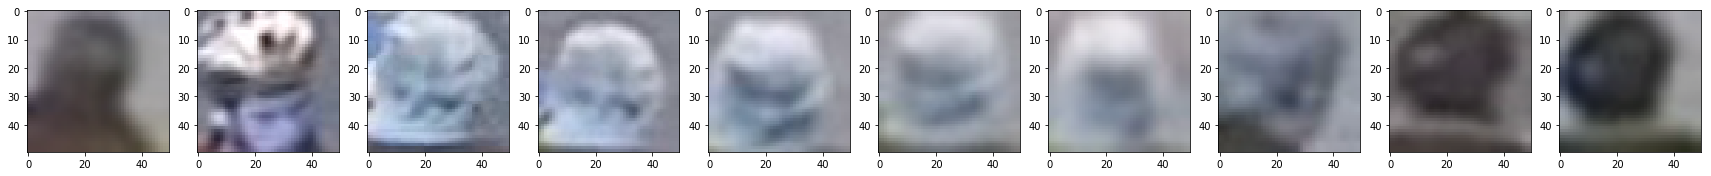

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1, 10, figsize=(30, 15))
for i in range(0, 10):
    axs[i].imshow(xtr[i])